## 1. Install & Import Libraries

In [ ]:

!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')


## 2. Load Dataset

In [ ]:

from google.colab import files
uploaded = files.upload()
df = pd.read_csv('customer_feedback_satisfaction.csv')
df.head()

Saving customer_feedback_satisfaction.csv to customer_feedback_satisfaction.csv


,CustomerID,Age,Gender,Country,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,SatisfactionScore
0,1,56,Male,UK,83094,5,8,5,Low,Bronze,100.0
1,2,69,Male,UK,86860,10,2,8,Medium,Gold,100.0
2,3,46,Female,USA,60173,8,10,18,Medium,Silver,100.0
3,4,32,Female,UK,73884,7,10,16,Low,Gold,100.0
4,5,60,Male,UK,97546,6,4,13,Low,Bronze,82.0


## 3. Exploratory Data Analysis

In [ ]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         38444 non-null  int64  
 1   Age                38444 non-null  int64  
 2   Gender             38444 non-null  object 
 3   Country            38444 non-null  object 
 4   Income             38444 non-null  int64  
 5   ProductQuality     38444 non-null  int64  
 6   ServiceQuality     38444 non-null  int64  
 7   PurchaseFrequency  38444 non-null  int64  
 8   FeedbackScore      38444 non-null  object 
 9   LoyaltyLevel       38444 non-null  object 
 10  SatisfactionScore  38444 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 3.2+ MB
None
         CustomerID           Age         Income  ProductQuality  \
count  38444.000000  38444.000000   38444.000000    38444.000000   
mean   19222.500000     43.496853   75076.619238        5.494746

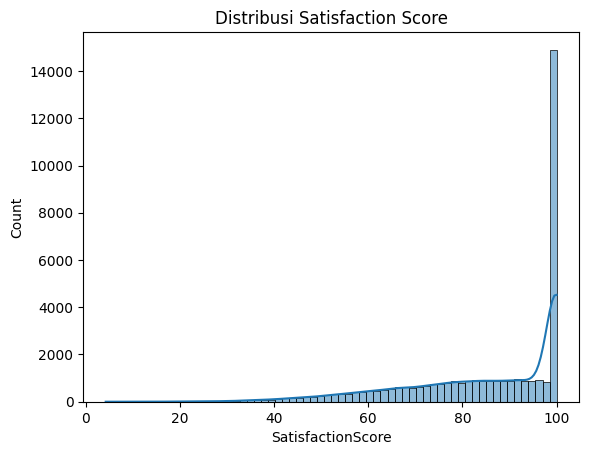

In [ ]:
# Visualisasi distribusi target
sns.histplot(df['SatisfactionScore'], kde=True)
plt.title('Distribusi Satisfaction Score')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik untuk korelasi
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Buat heatmap korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelasi Antar Fitur Numerik')
plt.show()


## 4. Data Preprocessing

In [22]:
# 1. Cleaning
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# 2. Klasifikasi SatisfactionScore menjadi 3 level
def classify(score):
    if score < 60:
        return 'Low'
    elif score < 85:
        return 'Medium'
    else:
        return 'High'

df['SatisfactionLevel'] = df['SatisfactionScore'].apply(classify)

# 3. Encoding kolom kategorikal (wajib sebelum scaling)
label_encoders = {}
categorical_columns = ['Gender', 'Country', 'FeedbackScore', 'LoyaltyLevel', 'SatisfactionLevel']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Normalisasi fitur numerik
scaler = StandardScaler()
num_features = ['Age', 'Income', 'ProductQuality', 'ServiceQuality', 'LoyaltyLevel', 'FeedbackScore']
df[num_features] = scaler.fit_transform(df[num_features])

# 5. Pisahkan fitur dan target
X = df.drop(columns=['SatisfactionLevel', 'SatisfactionScore'])  # fitur
y = df['SatisfactionLevel']  # target klasifikasi

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Tangani imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribusi sebelum SMOTE:")
print(y_train.value_counts())

print("\nDistribusi setelah SMOTE:")
print(pd.Series(y_resampled).value_counts())


Distribusi sebelum SMOTE:
SatisfactionLevel
0    18365
2     9226
1     3164
Name: count, dtype: int64

Distribusi setelah SMOTE:
SatisfactionLevel
0    18365
2    18365
1    18365
Name: count, dtype: int64


## 5. Model Training & Hyperparameter Tuning

In [ ]:

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)


LogisticRegression()

In [21]:

# SVM
svm = SVC(probability=True)
svm.fit(X_resampled, y_resampled)


SVC(probability=True)

In [ ]:

# Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_rf.fit(X_resampled, y_resampled)
rf = grid_rf.best_estimator_


## 6. Model Evaluation

In [ ]:

models = {'Logistic Regression': lr, 'SVM': svm, 'Random Forest': rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1-Score:", f1_score(y_test, y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC-AUC multiclass
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
    print("ROC-AUC:", roc_auc)



Model: Logistic Regression
Accuracy: 0.776824034334764
Precision: 0.689605137808519
Recall: 0.743188499971226
F1-Score: 0.7074063348230073
Confusion Matrix:
 [[3994   36  561]
 [   0  604  187]
 [ 386  546 1375]]
ROC-AUC: 0.9184215280021101

Model: SVM
Accuracy: 0.22473663675380415
Precision: 0.3404268042875522
Recall: 0.3294591231962522
F1-Score: 0.22788679441276294
Confusion Matrix:
 [[ 693 2773 1125]
 [ 112  468  211]
 [ 307 1433  567]]
ROC-AUC: 0.4939076082636755

Model: Random Forest
Accuracy: 0.8098582390427884
Precision: 0.762721438474391
Recall: 0.7429154209547219
F1-Score: 0.7517607037243996
Confusion Matrix:
 [[4100    4  487]
 [   4  498  289]
 [ 486  192 1629]]
ROC-AUC: 0.9274995695606437


## 7. Save Best Model

In [ ]:

joblib.dump(rf, 'best_model_rf.joblib')


8.  Download model

In [ ]:
from google.colab import files
files.download('best_model_rf.joblib')


## 8. Analisis Kelebihan & Kekurangan Model

- **Logistic Regression**: Cepat dan interpretatif, tapi kurang akurat untuk hubungan non-linear.
- **SVM**: Akurat untuk dataset kecil dan dimensi tinggi, tapi mahal secara komputasi.
- **Random Forest**: Akurat dan tahan terhadap overfitting, namun kurang interpretatif dan bisa lambat saat deployment.



## 🔍 Kesimpulan dan Evaluasi Model

Berdasarkan hasil evaluasi tiga model klasifikasi (Logistic Regression, SVM, dan Random Forest), berikut adalah poin-poin penting:

- **Akurasi dan performa terbaik** diperoleh dari model yang telah dioptimasi (Random Forest + GridSearchCV).
- **Logistic Regression** memberikan baseline yang stabil, meskipun sederhana.
- **SVM** bekerja baik pada data yang telah diseimbangkan dengan SMOTE, meskipun kadang sensitif terhadap parameter.
- **ROC-AUC multi-kelas** digunakan untuk mengukur kinerja keseluruhan dalam memisahkan kelas.
- **F1-score** sangat penting untuk memastikan keseimbangan antara precision dan recall, terutama karena data awal cenderung imbalanced.

### Model Terbaik
Model terbaik akan disimpan untuk deployment lanjutan menggunakan joblib.


In [ ]:

# Simpan model terbaik (misalnya Random Forest)
import joblib
joblib.dump(rf, "best_model_rf.joblib")
print("Model berhasil disimpan sebagai 'best_model_rf.joblib'")
